In [1]:
from torch.utils.data import DataLoader, TensorDataset
from gensim.models import Word2Vec
from tqdm.auto import tqdm
from torch.optim import Adam
from IPython.display import display
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import scipy.sparse as sp
import lightgbm as lgb
import shap

In [4]:
songs = pd.read_csv('kkbox/songs.csv')
songs_extra = pd.read_csv('kkbox/song_extra_info.csv')
songs = songs.merge(songs_extra, on='song_id', how='left')
songs = songs[['song_id', 'artist_name', 'name']]

После merge songs и song_extra_info встречаются дубликаты: песни с разными id, но одинаковыми артистами+названиями. Чтобы потом слить эту табличку с data, хотим сохранить все ids, но убрать дубликаты.

In [5]:
songs = (songs.groupby(['artist_name', 'name']).apply(lambda x: list(x['song_id'])).reset_index(name='song_ids'))

song_id2idx = dict()
for index, data in songs.iterrows():
    song_ids = data['song_ids']
    for song_id in song_ids:
        song_id2idx[song_id] = index
        
songs = songs[['artist_name', 'name']]

In [6]:
emb_size = 50
full_names = list(zip(songs['artist_name'], songs['name']))
w2v_model = Word2Vec(size=emb_size)
w2v_model.build_vocab(full_names)
w2v_model.train(full_names, total_examples=w2v_model.corpus_count, epochs=20)

voc = w2v_model.wv
trained_words = voc.vocab
trained_embs = voc.vectors

In [7]:
def get_embs(songs, trained_words, trained_embs, emb_size):
    n_songs = len(songs)
    song_embs = np.zeros((n_songs, 2 * emb_size))
    
    for song_id, row in songs.iterrows():
        art_name = row['artist_name']
        song_name = row['name']

        if art_name in trained_words:
            art_name_id = trained_words[art_name].index
            art_name_emb = trained_embs[art_name_id].reshape(1, -1)     
        else:
            art_name_emb = np.zeros((1, emb_size))

        if song_name in trained_words:
            song_name_id = trained_words[song_name].index
            song_name_emb = trained_embs[song_name_id].reshape(1, -1)
        else:
            song_name_emb = np.zeros((1, emb_size))

        song_emb = np.hstack((art_name_emb, song_name_emb))
        song_embs[song_id] = song_emb 
    return song_embs

In [8]:
full_name_embs = get_embs(songs, trained_words, trained_embs, emb_size)

## 1. Similars

In [9]:
data = pd.read_csv('kkbox/train.csv')
unique_users = np.unique(data['msno'])
n_users = len(unique_users)
user2idx = dict(zip(unique_users, range(n_users)))
idx2user = dict(zip(range(n_users), unique_users))
data['msno'] = data['msno'].apply(lambda x: user2idx[x])

# counting how many times a song was listened so that we sample similars only for popular ones
data['song_id'] = data['song_id'].apply(lambda x: song_id2idx[x] if x in song_id2idx else np.nan)
data.dropna(subset=['song_id'], inplace=True)
data['song_id'] = data['song_id'].apply(lambda x: int(x))

song_count = pd.DataFrame(data['song_id'])
song_count['song_count'] = song_count.groupby(['song_id'])['song_id'].transform('count')
song_count.drop_duplicates(inplace=True)
song_count.set_index(keys='song_id', inplace=True)

# building similars only for songs that were listened more than 1500 times and whose name and artist name
# are written in english 
popular_songs = songs.merge(song_count, left_index=True, right_index=True, how='inner')
popular_songs = popular_songs[popular_songs['song_count'] > 1500]
popular_songs['eng'] = popular_songs['artist_name'].apply(lambda x: int(x.isascii())) * popular_songs['name'].apply(lambda x: int(x.isascii()))
popular_songs = popular_songs[popular_songs['eng'] == 1]
popular_songs = popular_songs[['artist_name', 'name']]
popular_songs = popular_songs[popular_songs['artist_name'] != 'Various Artists']

In [10]:
def find_similars(x_emb, embs, k=10):    
    dist_fn = nn.CosineSimilarity()
    dist = dist_fn(torch.Tensor(x_emb), torch.Tensor(embs))
    sorted_idx = np.argsort(dist)
    top_k = sorted_idx[-k:-1].squeeze().tolist()[::-1]
    return pd.DataFrame(songs.iloc[top_k])

In [11]:
for _ in range(5):
    x = popular_songs.sample()
    song_id = x.index  
    print('For')
    display(x[['artist_name', 'name']])
 
    print('Similars are:')
    similars = find_similars(full_name_embs[song_id], full_name_embs)
    display(similars[['artist_name', 'name']])
    print('------------------')

For


,artist_name,name
128598,BIGBANG,LAST DANCE


Similars are:


,artist_name,name
128674,BIGBANG,V.I.P
128516,BIGBANG,A Good Man
128597,BIGBANG,LA LA LA
128568,BIGBANG,GIRLFRIEND
128614,BIGBANG,Liquid Gold
128518,BIGBANG,Ain't No Fun
128681,BIGBANG,We Like 2 Party
128528,BIGBANG,BLUE
128694,BIGBANG,一天一天


------------------
For


,artist_name,name
672463,John Mayer,Love on the Weekend


Similars are:


,artist_name,name
672460,John Mayer,Love Song For No One
672494,John Mayer,Split Screen Sadness
672493,John Mayer,Speak For Me
672492,John Mayer,Something's Missing
672491,John Mayer,Something Like Olivia
672490,John Mayer,Slow Dancing in a Burning Room
672489,John Mayer,Slow Dancing In A Burning Room
672488,John Mayer,Shadow Days
672486,John Mayer,Sannyasin Two


------------------
For


,artist_name,name
120675,Austin Mahone,Shake It For Me (feat. 2 Chainz)


Similars are:


,artist_name,name
120677,Austin Mahone,The One I've Waited For
120675,Austin Mahone,Shake It For Me (feat. 2 Chainz)
120673,Austin Mahone,Send It (feat. Rich Homie Quan)
120671,Austin Mahone,Say You're Just a Friend (feat. Flo Rida)
120657,Austin Mahone,Lady (feat. Pitbull)
120670,Austin Mahone,Say You're Just A Friend
120651,Austin Mahone,Do It Right (feat. Rob Villa)
120653,Austin Mahone,Except For Us
120654,Austin Mahone,Hate To Let You Go


------------------
For


,artist_name,name
128940,BIRDY,Keeping Your Head Up


Similars are:


,artist_name,name
128923,BIRDY,Farewell and Goodnight
128977,BIRDY,Warten
128978,BIRDY,West Stream
128982,BIRDY,Wings Acoustic
128985,BIRDY,Without A Word
128987,BIRDY,Words As Weapons
128988,BIRDY,You Used To Shine
128926,BIRDY,Flowers for You
128920,BIRDY,Dancing Snowflakes


------------------
For


,artist_name,name
849497,Maroon 5,Maps


Similars are:


,artist_name,name
1132825,Runaground,Maps
1351663,The Ukulele Boys,Maps
826084,Madilyn Bailey,Maps
794760,Look Up to the Billboard,Maps
993643,Our Last Night,Maps
157603,Ben Woodward,Maps
825200,Macy Gray,Maps
1533247,Vuducru,Maps
849517,Maroon 5,Payphone


------------------


## 2. Recommender

Чтобы сделать implicit матрицу надо убрать песни, которые никто не слушал вообще или слушал без повтора. 

In [12]:
data_imp = data[data['target'] == 1]
listened_songs = np.unique(data_imp['song_id'])
listened_embs = full_name_embs[listened_songs]
n_listened = len(listened_songs)
old_idx2idx = dict(zip(listened_songs, range(n_listened)))
idx2old_idx = dict(zip(range(n_listened), listened_songs))
data_imp['song_id'] = data_imp['song_id'].apply(lambda x: old_idx2idx[x])

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [23]:
def to_csr(data, rows, cols):
    user_item = sp.coo_matrix((data, (rows, cols)))
    user_item_csr = user_item.tocsr()
    return user_item_csr

def ALS(rating, item, epochs, lambd):
    for i in tqdm(range(epochs)):
        user = als_step(item, rating, lambd)
    return user
    
def als_step(fixed, rating, lambd):
    X = fixed.T @ fixed + lambd * np.eye(fixed.shape[1])
    X = np.linalg.inv(X)
    X = fixed @ X.T
    a = rating @ X
    return rating @ X

In [24]:
# implicit data, sparse matrix
user_imp = data_imp['msno']
song_imp = data_imp['song_id']
user_item = to_csr(np.ones_like(user_imp), user_imp, song_imp)

# one-step ALS
V = listened_embs
U = ALS(user_item, V, epochs=100, lambd=0.01)

In [51]:
class Recommender(nn.Module):
    def __init__(self, user_embs, song_embs, emb_size, hidden_size=64):
        super().__init__()
        self.Emedding_user = nn.Embedding.from_pretrained(torch.Tensor(user_embs))
        self.Embedding_song = nn.Embedding.from_pretrained(torch.Tensor(song_embs))
        
        self.fc1 = nn.Linear(emb_size * 2, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, 1)
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        user_id, song_id = x[:, 0], x[:, 1]
        user_emb = self.Emedding_user(user_id)
        song_emb = self.Embedding_song(song_id)
        emb = torch.cat((user_emb, song_emb), dim=1)
        
        x = self.fc1(emb)
        x = self.relu(x)
        x = self.fc2(x)
        return self.Sigmoid(x)

In [63]:
X = torch.LongTensor(data[['msno', 'song_id']].to_numpy())
y = torch.Tensor(data['target'].to_numpy()).unsqueeze(1)

kf = KFold(n_splits=5, shuffle=True)

test_aucs = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    train_dataset = TensorDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
    test_dataset = TensorDataset(X_test, y_test)
    test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=True)

    rec = Recommender(U, full_name_embs, 2 * emb_size)
    optim = Adam(rec.parameters())
    loss_fn = nn.BCELoss()
    epochs = 10

    for i in tqdm(range(epochs)):
        avg_loss = 0
        steps = 0
        for x, y_true in tqdm(train_dataloader):
            y_pred = rec(x)
            loss = loss_fn(y_pred, y_true)
            optim.zero_grad()
            loss.backward()
            optim.step()
            avg_loss += loss.item()
            steps += 1
        print(f'Epoch {i + 1} / {epochs}. Loss: {avg_loss/steps}')

    for x, y_true in tqdm(test_dataloader):
        avg_auc = 0
        steps = 0
        with torch.no_grad():
            y_pred = rec(x)
            avg_auc += roc_auc_score(y_true, y_pred)
            steps += 1
    test_auc = avg_auc/steps
    print(f'Test auc: {test_auc}')
    test_aucs.append(test_auc)


Epoch 1 / 10. Loss: 0.6717457712244784



Epoch 2 / 10. Loss: 0.6643421555090836



Epoch 3 / 10. Loss: 0.6605200386183886



Epoch 4 / 10. Loss: 0.6577029122094944



Epoch 5 / 10. Loss: 0.6552971293896038



Epoch 6 / 10. Loss: 0.6533567621934213



Epoch 7 / 10. Loss: 0.6516866981000634



Epoch 8 / 10. Loss: 0.6502092010379562



Epoch 9 / 10. Loss: 0.648845165125016



Epoch 10 / 10. Loss: 0.6476039804871165




Test auc: 0.6881132725081769



Epoch 1 / 10. Loss: 0.6716833033330859



Epoch 2 / 10. Loss: 0.6640921955966668



Epoch 3 / 10. Loss: 0.6601531794040997



Epoch 4 / 10. Loss: 0.6572527425706584



Epoch 5 / 10. Loss: 0.6549183187976223



Epoch 6 / 10. Loss: 0.6529396016027248



Epoch 7 / 10. Loss: 0.6512710809314621



Epoch 8 / 10. Loss: 0.6497417666133071



Epoch 9 / 10. Loss: 0.6483520649589434



Epoch 10 / 10. Loss: 0.6471813904542011




Test auc: 0.6630938929244014



Epoch 1 / 10. Loss: 0.6713167597865678



Epoch 2 / 10. Loss: 0.663457900901108



Epoch 3 / 10. Loss: 0.6593225969636107



Epoch 4 / 10. Loss: 0.6562127601390867



Epoch 5 / 10. Loss: 0.6536039063526321



Epoch 6 / 10. Loss: 0.65144918665339



Epoch 7 / 10. Loss: 0.6496390075127574



Epoch 8 / 10. Loss: 0.6481672279871568



Epoch 9 / 10. Loss: 0.6468042369189205



Epoch 10 / 10. Loss: 0.6457141066267738




Test auc: 0.6719111822883979



Epoch 1 / 10. Loss: 0.6718953334890098



Epoch 2 / 10. Loss: 0.6641870178262869



Epoch 3 / 10. Loss: 0.6603331841488338



Epoch 4 / 10. Loss: 0.6575480680715576



Epoch 5 / 10. Loss: 0.655418834544792



Epoch 6 / 10. Loss: 0.6535870366040233



Epoch 7 / 10. Loss: 0.651873073653589



Epoch 8 / 10. Loss: 0.6503211078328555



Epoch 9 / 10. Loss: 0.6489632493730181



Epoch 10 / 10. Loss: 0.6476316183221107




Test auc: 0.6440281283030265



Epoch 1 / 10. Loss: 0.671656053026538



Epoch 2 / 10. Loss: 0.6637434141618933



Epoch 3 / 10. Loss: 0.6598059221127371



Epoch 4 / 10. Loss: 0.6569460951555899



Epoch 5 / 10. Loss: 0.6547376391024261



Epoch 6 / 10. Loss: 0.6527506003420365



Epoch 7 / 10. Loss: 0.6510132349098017



Epoch 8 / 10. Loss: 0.6495260683774079



Epoch 9 / 10. Loss: 0.6481427862043081



Epoch 10 / 10. Loss: 0.6470095415961798




Test auc: 0.6821334428071388


In [64]:
print('Average 5-fold test AUC: {:.3f}' .format(np.mean(test_aucs)))

Average 5-fold test AUC: 0.670


## 3. Unclassical embedding + GB

In [86]:
# from GBDT.py: only features that were marked as significant via shapley values

# 'membership_duration_m' and 'expiration_year' 
members = pd.read_csv('kkbox/members.csv')
members['msno'] = members['msno'].apply(lambda x: user2idx[x] if x in user2idx else np.nan)
members.dropna(subset=['msno'], inplace=True)
members['msno'] = members['msno'].apply(lambda x: int(x))

members['expiration_date'] = pd.to_datetime(members['expiration_date'], format='%Y%m%d')
members['registration_init_time'] = pd.to_datetime(members['registration_init_time'], format='%Y%m%d')
members['membership_duration_d'] = (members['expiration_date'] - members['registration_init_time']).dt.days 
members['membership_duration_m'] = members['membership_duration_d'] // 30
members = members.loc[~members['membership_duration_m'] < 0]
members['expiration_year'] = members['expiration_date'].apply(lambda x: int(str(x)[:4]))
data = data.merge(members, on='msno', how='left')


# 'song_repeated_rate'
data1 = data[['song_id', 'target']]
song_played = data1.groupby('song_id', as_index=False).count().rename(columns={'target': 'num_played'})
song_repeated = data1.groupby('song_id', as_index=False).sum().rename(columns={'target': 'num_repeated'})
song_rate = pd.merge(song_played, song_repeated, on='song_id')
song_rate['song_repeated_rate'] = round(song_rate['num_repeated'] / song_rate['num_played'], 1)
song_rate.loc[song_rate['num_played'] == 1, 'song_repeated_rate'] = np.nan
song_rate.drop(columns=['num_played', 'num_repeated'], inplace=True)
data = data.merge(song_rate, on='song_id', how='left')


# 'genre_ids' and 'artist_name'
songs_ = pd.read_csv('kkbox/songs.csv')
songs_['song_id'] = songs_['song_id'].apply(lambda x: song_id2idx[x] if x in song_id2idx else np.nan)
songs_.dropna(subset=['song_id'], inplace=True)
songs_['song_id'] = songs_['song_id'].apply(lambda x: int(x))

def return_first(x):
    return str(x).split('|')[0]

songs_['artist_name'] = songs_['artist_name'].apply(return_first)
songs_['genre_ids'] = songs_['genre_ids'].apply(return_first)
data = data.merge(songs_, on='song_id', how='left')


# 'artist_repeated_rate'
data1 = data[['artist_name', 'target']]
artist_played = data1.groupby('artist_name', as_index=False).count().rename(columns={'target': 'num_played'})
artist_repeated = data1.groupby('artist_name', as_index=False).sum().rename(columns={'target': 'num_repeated'})
artist_rate = pd.merge(artist_played, artist_repeated, on='artist_name', how='left')
artist_rate['artist_repeated_rate'] = round(artist_rate['num_repeated'] / artist_rate['num_played'], 1)
artist_rate.loc[artist_rate['num_played'] == 1, 'artist_repeated_rate'] = np.nan
artist_rate.drop(columns=['num_played', 'num_repeated'], inplace=True)
data = data.merge(artist_rate, on='artist_name', how='left')


data = data[['song_repeated_rate', 'source_type', 'msno', 'source_system_tab', 'source_screen_name', 'song_id', 
          'expiration_year', 'genre_ids', 'membership_duration_m', 'artist_repeated_rate', 'artist_name', 'target']]
data.drop_duplicates(inplace=True)

X = data[['song_repeated_rate', 'source_type', 'msno', 'source_system_tab', 'source_screen_name', 'song_id', 
          'expiration_year', 'genre_ids', 'membership_duration_m', 'artist_repeated_rate', 'artist_name']]
y = data['target']

category_cols = ['msno', 'song_id', 'source_system_tab', 'source_screen_name', 'source_type', 
                 'genre_ids', 'artist_name']
for col in category_cols:
    X[col] = X[col].astype('category')

Добавляем фичу - скор от рекомендера на основе w2v.

In [122]:
def get_score(user_id, song_id):
    with torch.no_grad():
        ids = torch.LongTensor([user_id, song_id]).unsqueeze(0)
        score = rec(ids)
    return score
        
X['rec_score'] = X.apply(lambda x: get_score(x['msno'], x['song_id']), axis=1)
X['rec_score'] = X['rec_score'].apply(lambda x: round(x[0][0].item(), 2))

In [138]:
kf = KFold(n_splits=5, shuffle=True)

params = {'objective': 'binary',
        'learning_rate': 0.1,
        'min_gain_to_split': 0.3,
        'num_leaves': 128,
        'max_depth': 10,
        'bagging_fraction': 0.95,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.9,
        'feature_fraction_seed': 1,
        'metric' : 'auc'}

category_cols = ['msno', 'song_id', 'source_system_tab', 'source_screen_name', 'source_type', 
                 'genre_ids', 'artist_name']

test_aucs = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    dtrain = lgb.Dataset(X_train, y_train)
    dtrain_watch = lgb.Dataset(X_train, y_train)
    model = lgb.train(params, train_set=dtrain, num_boost_round=200, valid_sets=dtrain_watch, verbose_eval=20,
                 categorical_feature=category_cols)
    
    y_test_pred = model.predict(X_test)
    score = roc_auc_score(y_test, y_test_pred)
    print('Test AUC: {:.3f}' .format(score))
    test_aucs.append(score)

/Applications/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['artist_name', 'genre_ids', 'msno', 'song_id', 'source_screen_name', 'source_system_tab', 'source_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Info] Number of positive: 3428372, number of negative: 3373024
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.132199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33198
[LightGBM] [Info] Number of data points in the train set: 6801396, number of used features: 12


/Applications/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Applications/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504069 -> initscore=0.016276
[LightGBM] [Info] Start training from score 0.016276
[20]	valid_0's auc: 0.772488
[40]	valid_0's auc: 0.781837
[60]	valid_0's auc: 0.785886
[80]	valid_0's auc: 0.788355
[100]	valid_0's auc: 0.790916
[120]	valid_0's auc: 0.793257
[140]	valid_0's auc: 0.7956
[160]	valid_0's auc: 0.797901
[180]	valid_0's auc: 0.799811
[200]	valid_0's auc: 0.801962
Test AUC: 0.793


/Applications/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['artist_name', 'genre_ids', 'msno', 'song_id', 'source_screen_name', 'source_system_tab', 'source_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Info] Number of positive: 3428201, number of negative: 3373195
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.180133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33104
[LightGBM] [Info] Number of data points in the train set: 6801396, number of used features: 12


/Applications/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Applications/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504044 -> initscore=0.016175
[LightGBM] [Info] Start training from score 0.016175
[20]	valid_0's auc: 0.772609
[40]	valid_0's auc: 0.781789
[60]	valid_0's auc: 0.785681
[80]	valid_0's auc: 0.788221
[100]	valid_0's auc: 0.790847
[120]	valid_0's auc: 0.793351
[140]	valid_0's auc: 0.795576
[160]	valid_0's auc: 0.797668
[180]	valid_0's auc: 0.799812
[200]	valid_0's auc: 0.801474
Test AUC: 0.793


/Applications/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['artist_name', 'genre_ids', 'msno', 'song_id', 'source_screen_name', 'source_system_tab', 'source_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Info] Number of positive: 3428197, number of negative: 3373199
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.126120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33100
[LightGBM] [Info] Number of data points in the train set: 6801396, number of used features: 12


/Applications/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Applications/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504043 -> initscore=0.016173
[LightGBM] [Info] Start training from score 0.016173
[20]	valid_0's auc: 0.772617
[40]	valid_0's auc: 0.78177
[60]	valid_0's auc: 0.785467
[80]	valid_0's auc: 0.788244
[100]	valid_0's auc: 0.790709
[120]	valid_0's auc: 0.793067
[140]	valid_0's auc: 0.795547
[160]	valid_0's auc: 0.797662
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[180]	valid_0's auc: 0.799581
[200]	valid_0's auc: 0.801441
Test AUC: 0.792


/Applications/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['artist_name', 'genre_ids', 'msno', 'song_id', 'source_screen_name', 'source_system_tab', 'source_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Info] Number of positive: 3429718, number of negative: 3371678
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.122019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33306
[LightGBM] [Info] Number of data points in the train set: 6801396, number of used features: 12


/Applications/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Applications/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504267 -> initscore=0.017067
[LightGBM] [Info] Start training from score 0.017067
[20]	valid_0's auc: 0.77226
[40]	valid_0's auc: 0.781408
[60]	valid_0's auc: 0.785396
[80]	valid_0's auc: 0.78807
[100]	valid_0's auc: 0.790685
[120]	valid_0's auc: 0.792931
[140]	valid_0's auc: 0.795515
[160]	valid_0's auc: 0.797355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[180]	valid_0's auc: 0.799244
[200]	valid_0's auc: 0.801242
Test AUC: 0.793


/Applications/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['artist_name', 'genre_ids', 'msno', 'song_id', 'source_screen_name', 'source_system_tab', 'source_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Info] Number of positive: 3428856, number of negative: 3372540
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33080
[LightGBM] [Info] Number of data points in the train set: 6801396, number of used features: 12


/Applications/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Applications/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504140 -> initscore=0.016561
[LightGBM] [Info] Start training from score 0.016561
[20]	valid_0's auc: 0.772494
[40]	valid_0's auc: 0.781877
[60]	valid_0's auc: 0.785833
[80]	valid_0's auc: 0.788534
[100]	valid_0's auc: 0.791317
[120]	valid_0's auc: 0.793875
[140]	valid_0's auc: 0.796295
[160]	valid_0's auc: 0.798309
[180]	valid_0's auc: 0.800129
[200]	valid_0's auc: 0.802003
Test AUC: 0.793


In [139]:
print('Average 5-fold test AUC: {:.3f}' .format(np.mean(test_aucs)))

Average 5-fold test AUC: 0.793


Average 5-fold test AUC GB с теми же гиперпараметрами и фичами кроме скора от рекомендера: 0.775.
Рекомендер показывает какую-то точность, отличную от 0.5, поэтому можно сказать, что он более-менее нормально предсказывает таргет. Поэтому добавив скор, мы на самом деле добавили неплохую оценку таргета. Ожидаем, что shapley values покажут, что скор от рекомендера - самый важный фактор.

In [21]:
shap_values = shap.TreeExplainer(model).shap_values(X_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


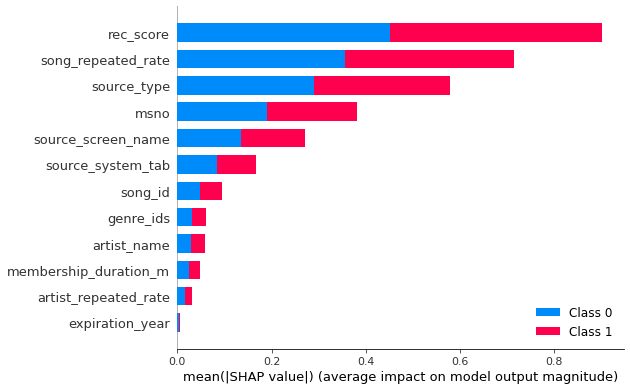

In [23]:
shap.summary_plot(shap_values, X_train)